In [517]:
import xgboost as xgb
from data_utils import load_features, preds_to_df
from transforms import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import roc_auc_score
import os
import pandas as pd
%matplotlib inline

In [527]:
patient = 1

%time X_corr, y, files_1 = load_features('train_{}'.format(patient), [CorrelationMatrix()])
%time X_mean_abs, y, files_2 = load_features('train_{}'.format(patient), [Mean(), Abs()])
%time X_stats, y, files_3 = load_features('train_{}'.format(patient), [Stats()])
%time X_fft, y, files_3 = load_features('train_{}'.format(patient), [FFT(), Slice(1, 160), Magnitude(), Log10()])

Wall time: 115 ms
Wall time: 6 ms
Wall time: 37 ms
Wall time: 1.93 s


In [528]:
files_1[0], files_2[0], files_3[0]

('1_1000_0.mat', '1_1000_0.mat', '1_1000_0.mat')

In [529]:
X_fft = X_fft.reshape(X_fft.shape[0], X_fft.shape[1]*X_fft.shape[2])
X_stats = X_stats.reshape(X_stats.shape[0], X_stats.shape[1]*X_stats.shape[2])
X = np.hstack([X_fft, X_mean_abs, X_corr, X_stats])
sm = SMOTE(kind='regular')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1337)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [530]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [544]:
param = {'bst:max_depth':2, 'bst:eta':.5, 'silent':0, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist  = [(dtrain,'train'), (dtest,'eval')]
num_round = 100
bst = xgb.train( param, dtrain, num_round, evallist, early_stopping_rounds=4 )
roc_auc_score(np.round(bst.predict(dtrain)), y_train), roc_auc_score(np.round(bst.predict(dtest)), y_test)

Will train until eval error hasn't decreased in 4 rounds.
[0]	train-auc:0.736695	eval-auc:0.686439
[1]	train-auc:0.828814	eval-auc:0.707613
[2]	train-auc:0.878028	eval-auc:0.684672
[3]	train-auc:0.909074	eval-auc:0.683650
[4]	train-auc:0.924083	eval-auc:0.689818
[5]	train-auc:0.937439	eval-auc:0.687382
Stopping. Best iteration:
[1]	train-auc:0.828814	eval-auc:0.707613



(0.87407782762269548, 0.58512544802867383)

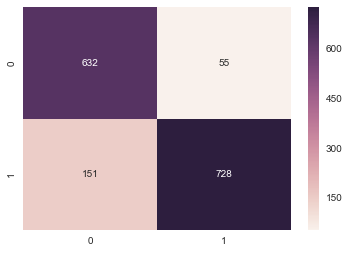

In [545]:
sns.heatmap(confusion_matrix(np.round(bst.predict(dtrain)), y_train), annot=True, fmt='d')
plt.show()

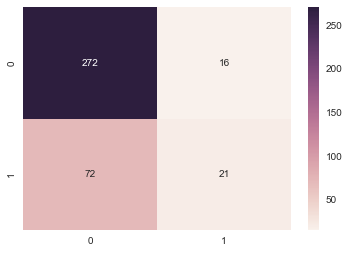

In [546]:
sns.heatmap(confusion_matrix(np.round(bst.predict(dtest)), y_test), annot=True, fmt='d')
plt.show()

In [526]:
%time X_corr, files_1 = load_features('test_{}'.format(patient), [CorrelationMatrix()])
%time X_mean_abs, files_2 = load_features('test_{}'.format(patient), [Mean(), Abs()])
%time X_stats, files_3 = load_features('test_{}'.format(patient), [Stats()])
%time X_fft, files_3 = load_features('test_{}'.format(patient), [FFT(), Slice(1, 160), Magnitude(), Log10()])
X_fft = X_fft.reshape(X_fft.shape[0], X_fft.shape[1]*X_fft.shape[2])
X_stats = X_stats.reshape(X_stats.shape[0], X_stats.shape[1]*X_stats.shape[2])
X = np.hstack([X_fft, X_mean_abs, X_corr, X_stats])


NameError: name 'patient' is not defined

In [513]:
dfinal = xgb.DMatrix(X)